# Repaso Machine Learning - Aprendizaje Supervisado - Regresion

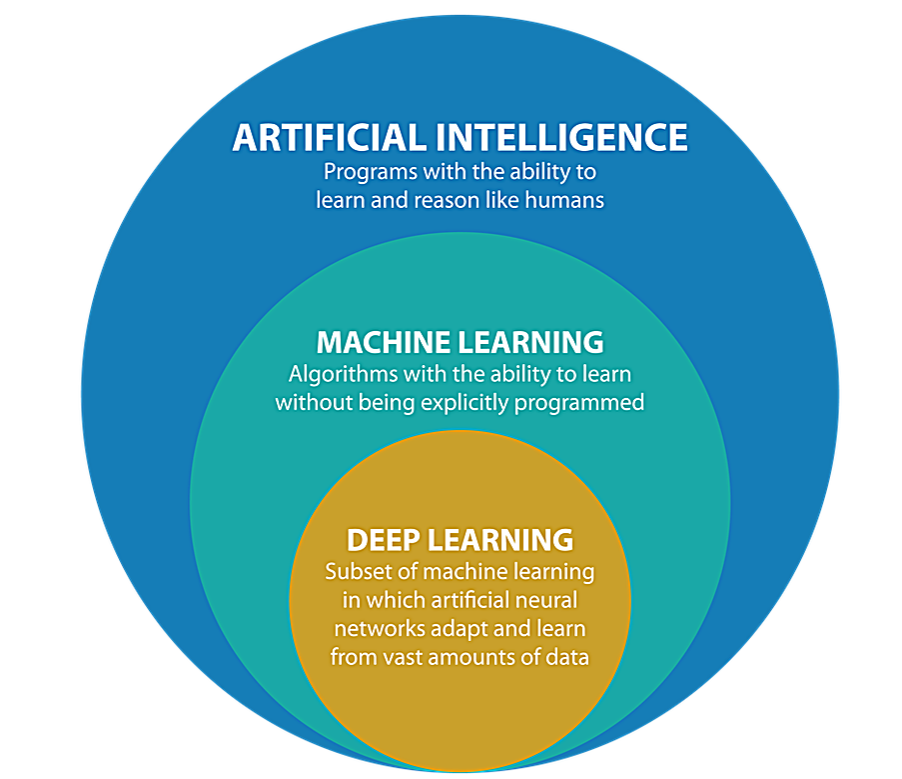

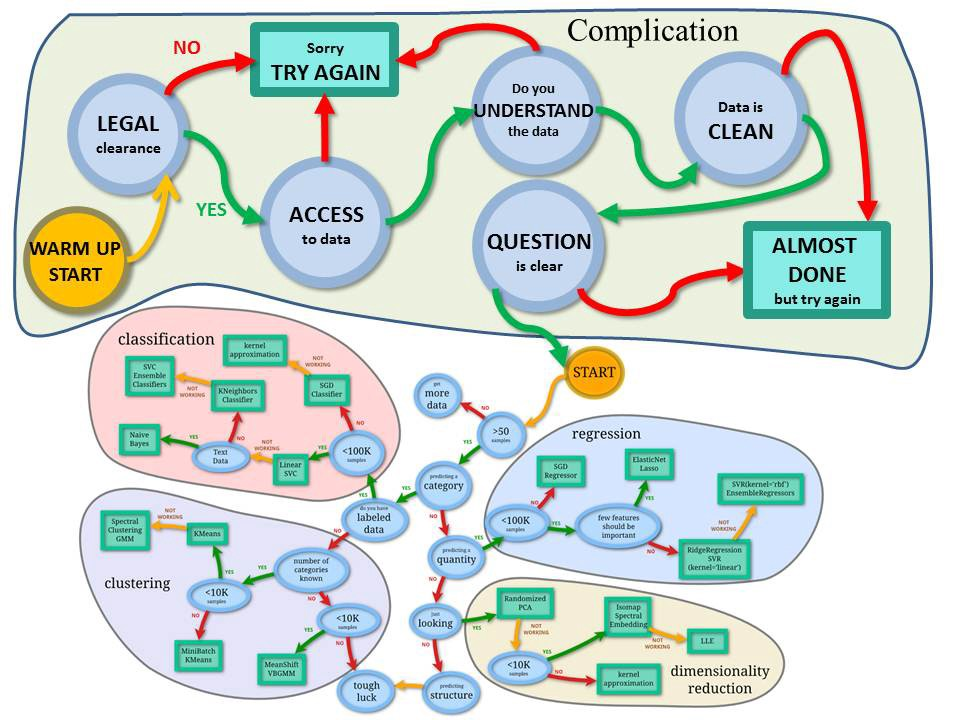

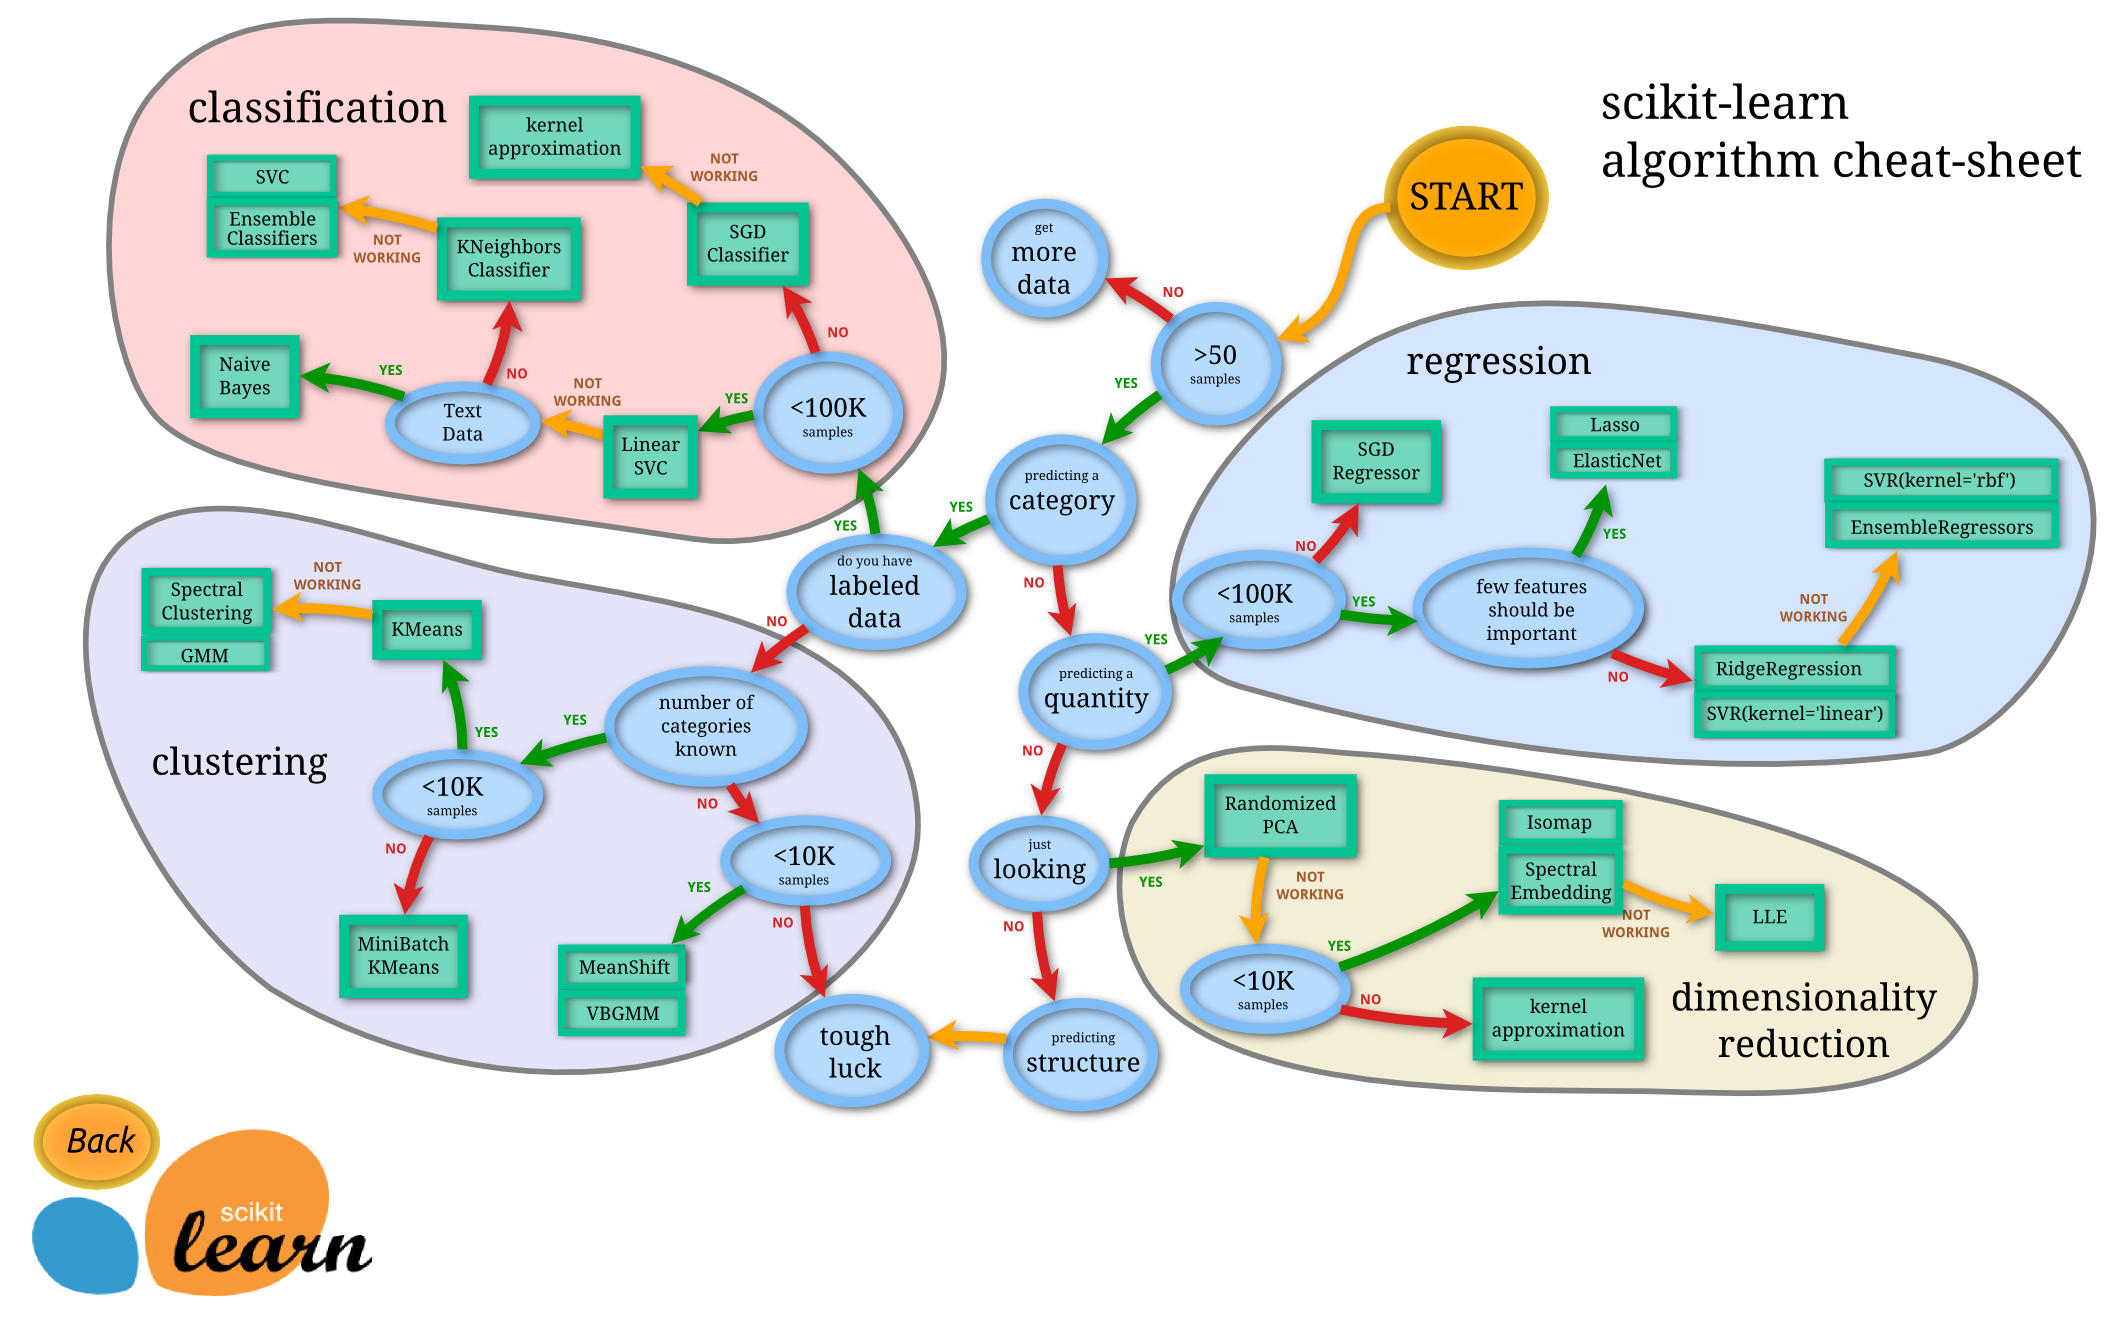

### WorkFlow


1. [Obtener datos](#1.-Obtener-Datos)
2. [Definir objetivo](#2.-Definir-Objetivo)
3. [Limpieza de datos (unidades, outliers, one-hot, etc..)(**)](#3.-Limpieza-de-Datos)
4. [Definir modelo (regresión, clasificación, ...)](#4.-Modelo)
5. [Entrenar (hiperparámetros, validación, ...) (**)](#5.-Entrenamiento)
6. [Predecir (testear)](#6.-Predicción)
7. [Evaluación](#7.-Evaluación)
8. [Si hay mucho error volver a (**)](#WorkFlow)
9. [Super-Bonus H2O](#8.-H2O)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import pylab as plt
import seaborn as sns

%matplotlib inline

### 1. Obtener Datos

**explicacion:**
    
+ carat:	peso del diamante (quilates)

+ cut:	calidad del corte (Fair, Ideal, Good, Very Good, Premium)

+ color: color (D (mejor) a J (peor))

+ clarity: claridad (I1 (peor), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (mejor)) 

+ table: ancho del corte superior del diamante

+ x: largo en mm

+ y: ancho en mm

+ z: alto en mm

+ depth:	2*z/(x+y)

+ price:	precio en dolares USA


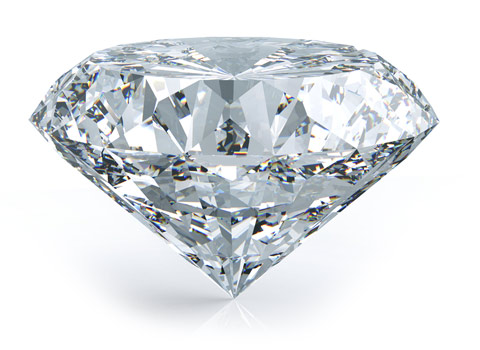

In [3]:
df=pd.read_csv('../Data/diamonds.csv')

df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,Premium,J,VS2,62.4,58.0,4268,6.83,6.79,4.25
1,0.32,Very Good,H,VS2,63.0,57.0,505,4.35,4.38,2.75
2,0.71,Fair,G,VS1,65.5,55.0,2686,5.62,5.53,3.65
3,0.41,Good,D,SI1,63.8,56.0,738,4.68,4.72,3.00
4,1.02,Ideal,G,SI1,60.5,59.0,4882,6.55,6.51,3.95


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40455 non-null  float64
 1   cut      40455 non-null  object 
 2   color    40455 non-null  object 
 3   clarity  40455 non-null  object 
 4   depth    40455 non-null  float64
 5   table    40455 non-null  float64
 6   price    40455 non-null  int64  
 7   x        40455 non-null  float64
 8   y        40455 non-null  float64
 9   z        40455 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.1+ MB


### 2. Definir Objetivo


```El objetivo del ejercicio consiste en predecir el precio de los diamantes basándonos en datos como el peso, el color, el corte o la claridad.```

### 3. Limpieza de Datos

El proceso de limpieza es el habitual:

+ Valores nulos
+ Datos inconsistentes 
+ Datos duplicados...

Todo esto implica realizar también un **EDA**. Además de eso, es necesario arreglar los datos, proceso llamado `data wrangling`. Este proceso consiste en preparar los datos de manera adecuada para que el modelo de machine learning "entienda" los datos de manera óptima. Por ejemplo, los datos de corte, color y claridad son datos categóricos que están en formato string, habrá que cambiar estos datos para alimentar al modelo, las máquinas solo entienden de números 🤣.

Este proceso no es solo necesario sino fundamental. **Todo está en los datos.**

In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40455 non-null  float64
 1   cut      40455 non-null  object 
 2   color    40455 non-null  object 
 3   clarity  40455 non-null  object 
 4   depth    40455 non-null  float64
 5   table    40455 non-null  float64
 6   price    40455 non-null  int64  
 7   x        40455 non-null  float64
 8   y        40455 non-null  float64
 9   z        40455 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 9.2 MB


In [6]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
carat,40455.0,NaN,NaN,NaN,0.797706,0.475544,0.2,0.4,0.7,1.04,4.5
cut,40455,5,Ideal,16220,NaN,NaN,NaN,NaN,NaN,NaN,NaN
color,40455,7,G,8455,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clarity,40455,8,SI1,9749,NaN,NaN,NaN,NaN,NaN,NaN,NaN
depth,40455.0,NaN,NaN,NaN,61.752841,1.431725,43.0,61.0,61.8,62.5,79.0
table,40455.0,NaN,NaN,NaN,57.446133,2.233535,43.0,56.0,57.0,59.0,95.0
price,40455.0,NaN,NaN,NaN,3928.444469,3992.416147,326.0,945.0,2397.0,5331.0,18823.0
x,40455.0,NaN,NaN,NaN,5.729392,1.124453,0.0,4.71,5.69,6.54,10.23
y,40455.0,NaN,NaN,NaN,5.732819,1.14665,0.0,4.72,5.71,6.54,58.9
z,40455.0,NaN,NaN,NaN,3.537154,0.697062,0.0,2.91,3.52,4.035,8.06


In [8]:
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

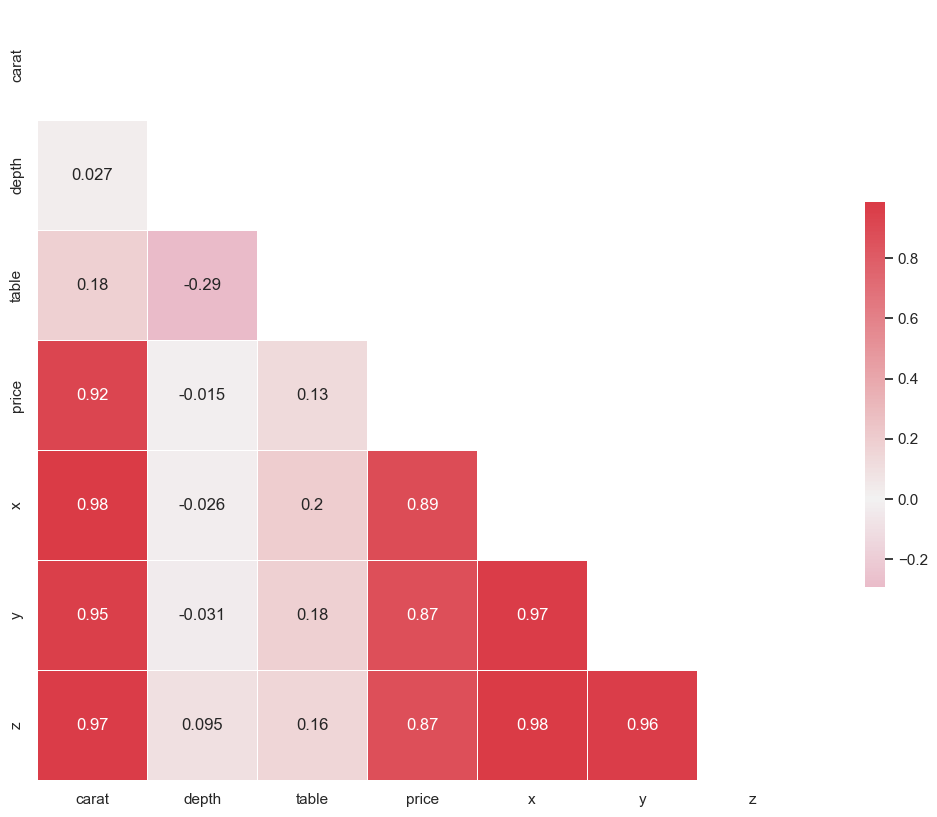

In [9]:
# buscando colinealidad

plt.figure(figsize=(15, 10))

sns.set(style='white')

mask=np.triu(np.ones_like(df[['carat', 'depth', 'table', 'price', 'x', 'y', 'z']].corr(), dtype=bool))

cmap=sns.diverging_palette(0, 10, as_cmap=True)


sns.heatmap(df[['carat', 'depth', 'table', 'price', 'x', 'y', 'z']].corr(),
           mask=mask,
          cmap=cmap,
          center=0,
          square=True,
          annot=True,
          linewidths=0.5,
          cbar_kws={'shrink': 0.5});

In [10]:
# scatter matrix

pd.plotting.scatter_matrix(df, figsize=(15, 10), alpha=0.2);

Error in callback <function flush_figures at 0x000001B0246D9C60> (for post_execute):


KeyboardInterrupt: 

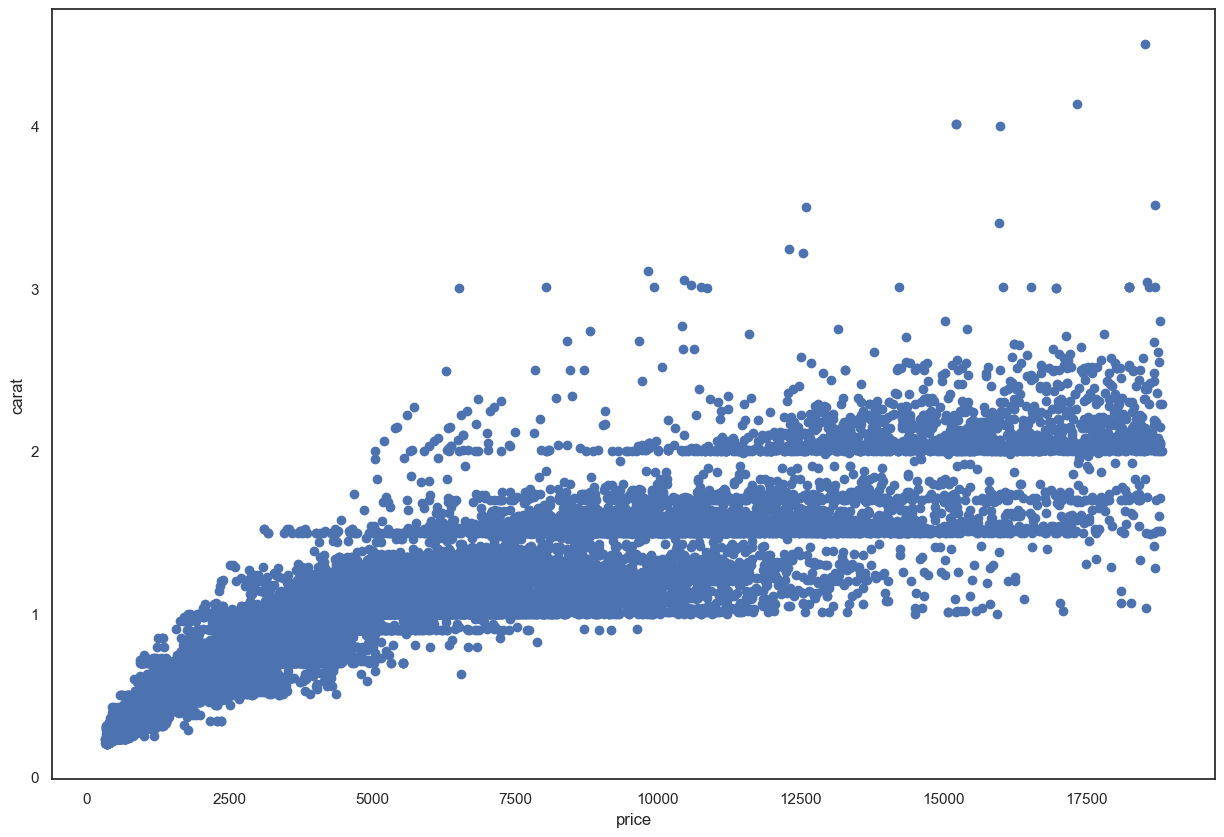

In [11]:
plt.figure(figsize=(15,10))

plt.scatter(df.price, df.carat)

plt.ylabel('carat')
plt.xlabel('price');

In [12]:
# transformando carat con boxcox

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html

from scipy.stats import boxcox

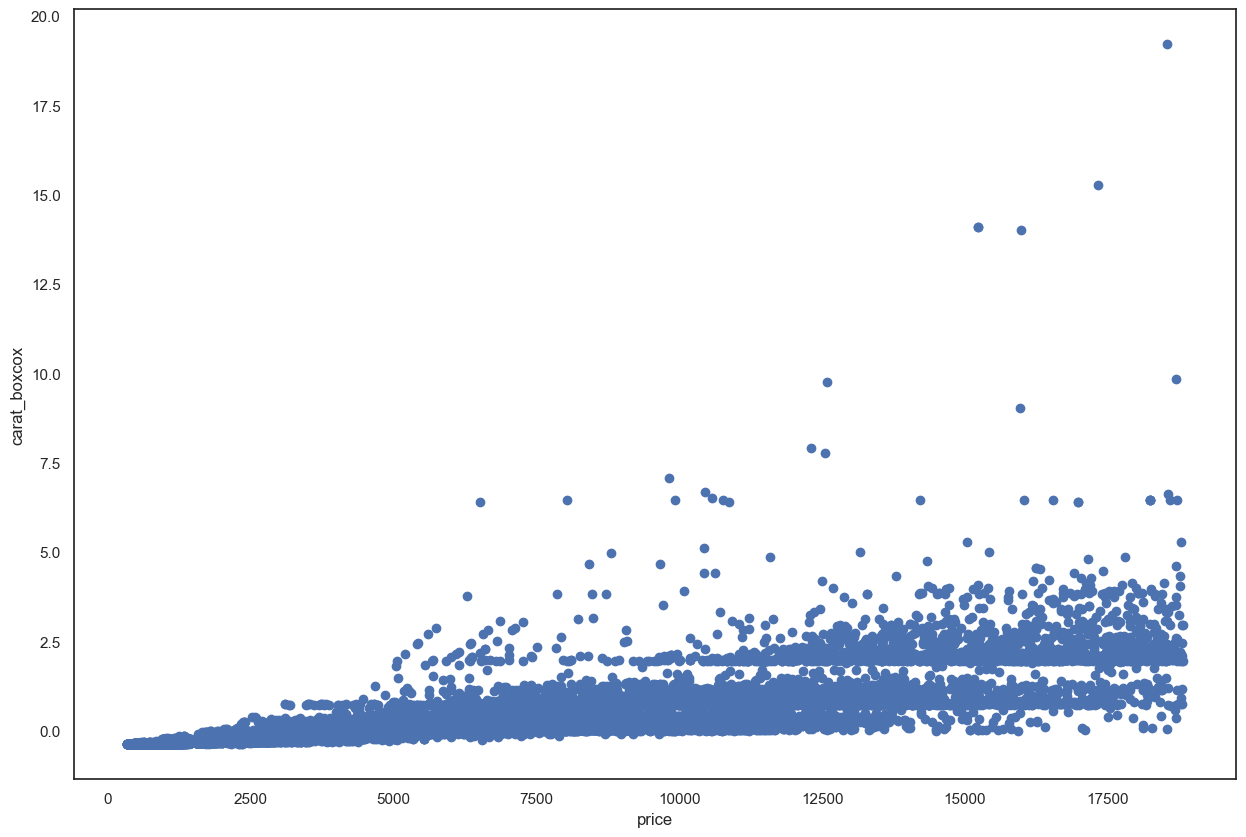

In [13]:
plt.figure(figsize=(15,10))


carat_boxcox=boxcox(df.carat, lmbda=2.618033)

plt.scatter(df.price, carat_boxcox)
plt.xlabel('price')
plt.ylabel('carat_boxcox');

## Reflexión : ¿Cómo podemos asegurarnos de que de verdad son diamantes?

1 carat es igual a 200mg de diamante.

Densidad del diamante es 2,26 gm/cm3

In [54]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,Premium,J,VS2,62.4,58.0,4268,6.83,6.79,4.25
1,0.32,Very Good,H,VS2,63.0,57.0,505,4.35,4.38,2.75
2,0.71,Fair,G,VS1,65.5,55.0,2686,5.62,5.53,3.65
3,0.41,Good,D,SI1,63.8,56.0,738,4.68,4.72,3.00
4,1.02,Ideal,G,SI1,60.5,59.0,4882,6.55,6.51,3.95


In [15]:
df2=df.copy()

df2['gr'] = 0.2 * df2.carat

df2['vol']=df2.x * df2.y * df2.z / 2.5 / 1000

df2['density']= df2.gr / df2.vol

df2.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,gr,vol,density
0,1.21,Premium,J,VS2,62.4,58.0,4268,6.83,6.79,4.25,0.242,0.078839,3.069559
1,0.32,Very Good,H,VS2,63.0,57.0,505,4.35,4.38,2.75,0.064,0.020958,3.053683
2,0.71,Fair,G,VS1,65.5,55.0,2686,5.62,5.53,3.65,0.142,0.045375,3.129493
3,0.41,Good,D,SI1,63.8,56.0,738,4.68,4.72,3.00,0.082,0.026508,3.093462
4,1.02,Ideal,G,SI1,60.5,59.0,4882,6.55,6.51,3.95,0.204,0.067372,3.027965


In [16]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
carat,40455.0,0.797706,0.475544,0.200000,0.400000,0.700000,1.040000,4.500000e+00
depth,40455.0,61.752841,1.431725,43.000000,61.000000,61.800000,62.500000,7.900000e+01
table,40455.0,57.446133,2.233535,43.000000,56.000000,57.000000,59.000000,9.500000e+01
price,40455.0,3928.444469,3992.416147,326.000000,945.000000,2397.000000,5331.000000,1.882300e+04
x,40455.0,5.729392,1.124453,0.000000,4.710000,5.690000,6.540000,1.023000e+01
y,40455.0,5.732819,1.146650,0.000000,4.720000,5.710000,6.540000,5.890000e+01
z,40455.0,3.537154,0.697062,0.000000,2.910000,3.520000,4.035000,8.060000e+00
gr,40455.0,0.159541,0.095109,0.040000,0.080000,0.140000,0.208000,9.000000e-01
vol,40455.0,0.051921,0.031562,0.000000,0.025956,0.045876,0.068338,1.536239e+00
density,40455.0,inf,NaN,0.260376,3.023931,3.058436,3.095017,inf


In [17]:
df2[df2.density > 4].shape

(27, 13)

## Separación de datos.

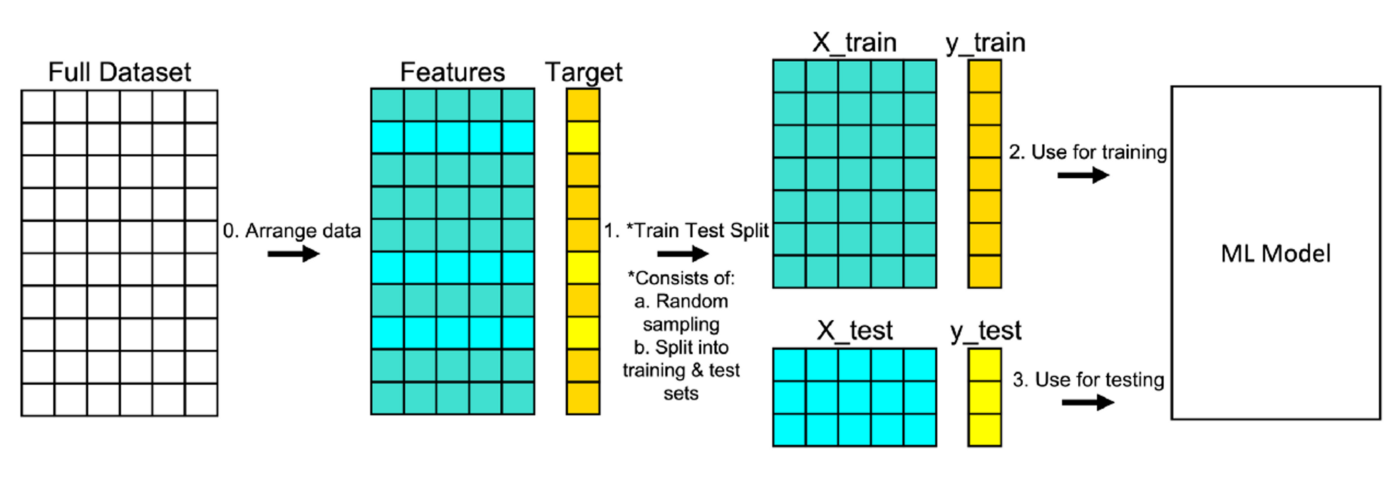

Antes de transformar definitivamente nada, vamos a separar los datos en X e y. y será la columna objetivo, es decir, el precio. La columna objetivo nunca se toca, nunca se transforma en ningún sentido. X serán el resto de columnas, la características con las que realizaremos nuestras predicciones.

**0 arreglar datos**

In [41]:
X = df.drop('price', axis=1)

y = df.price

X.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,1.21,Premium,J,VS2,62.4,58.0,6.83,6.79,4.25
1,0.32,Very Good,H,VS2,63.0,57.0,4.35,4.38,2.75
2,0.71,Fair,G,VS1,65.5,55.0,5.62,5.53,3.65
3,0.41,Good,D,SI1,63.8,56.0,4.68,4.72,3.00
4,1.02,Ideal,G,SI1,60.5,59.0,6.55,6.51,3.95


In [42]:
from sklearn.model_selection import train_test_split as tts # el alias es cosa mia

X_train, X_test, y_train, y_test = tts(X, y, train_size=0.8, test_size=0.2, random_state=22)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32364, 9), (8091, 9), (32364,), (8091,))

In [43]:
# transformacion boxcox

X_train.carat=boxcox(X_train.carat, lmbda=2.618033)
X_test.carat=boxcox(X_test.carat, lmbda=2.618033)

X_train.head()

,carat,cut,color,clarity,depth,table,x,y,z
20820,-0.337444,Good,D,VS2,60.6,64.0,4.97,4.89,2.99
32405,-0.277251,Premium,F,VVS2,59.7,58.0,5.56,5.53,3.31
1482,-0.365631,Premium,G,VS2,60.6,60.0,4.34,4.30,2.62
4884,-0.226149,Very Good,D,SI2,59.6,63.0,5.80,5.71,3.44
38970,-0.344959,Premium,F,SI1,59.8,59.0,4.85,4.82,2.89


In [44]:
X_train=X_train.drop('table', axis=1)
X_test=X_test.drop('table', axis=1)

X_train.head()

,carat,cut,color,clarity,depth,x,y,z
20820,-0.337444,Good,D,VS2,60.6,4.97,4.89,2.99
32405,-0.277251,Premium,F,VVS2,59.7,5.56,5.53,3.31
1482,-0.365631,Premium,G,VS2,60.6,4.34,4.30,2.62
4884,-0.226149,Very Good,D,SI2,59.6,5.80,5.71,3.44
38970,-0.344959,Premium,F,SI1,59.8,4.85,4.82,2.89


In [45]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

X_train[['depth', 'x', 'y', 'z']]=scaler.fit_transform(X_train[['depth', 'x', 'y', 'z']])
X_test[['depth', 'x', 'y', 'z']]=scaler.transform(X_test[['depth', 'x', 'y', 'z']])
X_test.head()

,carat,cut,color,clarity,depth,x,y,z
2227,0.010081,Premium,F,SI2,0.313267,0.625160,0.544840,0.637889
26308,0.000000,Ideal,G,VVS2,-0.453692,0.625160,0.640224,0.580386
547,-0.092078,Premium,E,SI2,-0.662862,0.429310,0.449456,0.364749
34504,0.722208,Good,G,I1,1.568289,1.266127,1.134485,-5.083669
25620,-0.231830,Ideal,G,VS1,-0.802309,-0.024708,0.015893,-0.095276


**transformando categoricas de varias maneras**

In [46]:
# one-hot encoding , variables dummies (esto funciona muy bien en regresion)
 
X_train=pd.get_dummies(X_train, columns=['cut'])   # drop_first=True, por defecto es False 
X_test=pd.get_dummies(X_test, columns=['cut'])   # drop_first=True, por defecto es False 

X_train.head()

,carat,color,clarity,depth,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good
20820,-0.337444,D,VS2,-0.802309,-0.674576,-0.729835,-0.785313,False,True,False,False,False
32405,-0.277251,F,VVS2,-1.429820,-0.149340,-0.174874,-0.325288,False,False,False,True,False
1482,-0.365631,G,VS2,-0.802309,-1.235422,-1.241439,-1.317216,False,False,False,True,False
4884,-0.226149,D,SI2,-1.499544,0.064315,-0.018792,-0.138403,False,False,False,False,True
38970,-0.344959,F,SI1,-1.360097,-0.781404,-0.790533,-0.929070,False,False,False,True,False


In [48]:
X_train["clarity"].unique()

array(['VS2', 'VVS2', 'SI2', 'SI1', 'IF', 'I1', 'VS1', 'VVS1'],
      dtype=object)

In [49]:
claridades = {
    "IF": 0,
    "VVS1": 1,
    "VVS2": 2,
    "SI1": 3,
    "SI2": 4,
    "I1": 5,
    "VS1": 6,
    "VS2": 7
}

In [50]:
X_train.clarity = X_train.clarity.apply(lambda x: claridades[x])
X_test.clarity = X_test.clarity.apply(lambda x: claridades[x])

In [ ]:
# label encoder

from sklearn.preprocessing import LabelEncoder

X_train.clarity=LabelEncoder().fit_transform(X.clarity)
X_test.clarity=LabelEncoder().transform(X.clarity)

X.head()

In [53]:
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,Premium,J,VS2,62.4,58.0,4268,6.83,6.79,4.25
1,0.32,Very Good,H,VS2,63.0,57.0,505,4.35,4.38,2.75
2,0.71,Fair,G,VS1,65.5,55.0,2686,5.62,5.53,3.65
3,0.41,Good,D,SI1,63.8,56.0,738,4.68,4.72,3.00
4,1.02,Ideal,G,SI1,60.5,59.0,4882,6.55,6.51,3.95
...,...,...,...,...,...,...,...,...,...,...
40450,1.34,Ideal,G,VS1,62.7,57.0,10070,7.10,7.04,4.43
40451,2.02,Good,F,SI2,57.1,60.0,12615,8.31,8.25,4.73
40452,1.01,Ideal,H,SI1,62.7,56.0,5457,6.37,6.42,4.01
40453,0.33,Ideal,J,VS1,61.9,54.3,456,4.45,4.47,2.76


In [66]:
df['price'] = pd.to_numeric(df['price'])

In [68]:
df.color

0        J
1        H
2        G
3        D
4        G
        ..
40450    G
40451    F
40452    H
40453    J
40454    I
Name: color, Length: 40455, dtype: object

In [72]:
pd.__version__

'2.1.1'

In [75]:
hola = df.groupby("color")

In [77]:
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

In [78]:
df.groupby("color").mean(['carat', 'depth', 'table', 'price', 'x', 'y', 'z'])

,carat,depth,table,price,x,y,z
color,,,,,,,
D,0.653036,61.721886,57.344959,3134.943157,5.404704,5.409541,3.336782
E,0.658835,61.659836,57.494567,3088.342526,5.413894,5.418651,3.338709
F,0.731503,61.689954,57.409726,3677.355720,5.601393,5.607254,3.455930
G,0.774382,61.752785,57.287889,4023.214902,5.684102,5.687183,3.508856
H,0.910355,61.827481,57.533503,4476.469014,5.981431,5.984082,3.693629
I,1.026791,61.873214,57.562574,5090.868800,6.216099,6.215675,3.842078
J,1.166500,61.909626,57.790701,5346.234112,6.527285,6.525570,4.039879


<Axes: xlabel='color', ylabel='price'>

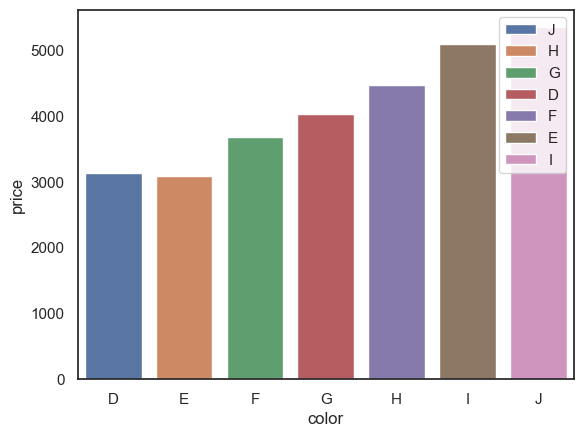

In [82]:
sns.barplot(x = df.groupby("color").mean(['carat', 'depth', 'table', 'price', 'x', 'y', 'z']).index,
            y = df.groupby('color').mean(['carat', 'depth', 'table', 'price', 'x', 'y', 'z']).price,
            hue = df["color"].unique())

In [55]:
# label encoder custom

color={'J': 1, 'I': 2, 'H': 5, 'G':15, 'F': 25, 'E': 30, 'D':45}  # aqui es donde entra el conocimiento experto


def cambio_color(x):   #esto es la lambda
    return color[x]    # x es una key del diccionario color, color[x] es el value

#X.color=X.color.apply(cambio_color)

X_train.color=X_train.color.apply(lambda x: color[x])
X_test.color=X_test.color.apply(lambda x: color[x])

X_test.head()

,carat,color,clarity,depth,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good
2227,0.010081,25,4,0.313267,0.625160,0.544840,0.637889,False,False,False,True,False
26308,0.000000,15,2,-0.453692,0.625160,0.640224,0.580386,False,False,True,False,False
547,-0.092078,30,4,-0.662862,0.429310,0.449456,0.364749,False,False,False,True,False
34504,0.722208,15,5,1.568289,1.266127,1.134485,-5.083669,False,True,False,False,False
25620,-0.231830,15,6,-0.802309,-0.024708,0.015893,-0.095276,False,False,True,False,False


**1 train test split**

In [106]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((32364, 12), (32364,), (8091, 12), (8091,))

Ahora ya podemos alimentar el modelo predictivo. Probaremos distintos modelos.

### 4. Modelo

**Regresión Lineal**

In [57]:
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.linear_model import Lasso        # regularizacion L1
from sklearn.linear_model import Ridge        # regularizacion L2
from sklearn.linear_model import ElasticNet   # regularizacion L1+L2


# se inician los modelos
linreg=LinReg()
lasso=Lasso()
ridge=Ridge()
elastic=ElasticNet()

**SVR**

In [58]:
from sklearn.svm import SVR  # support vector regressor

svr=SVR()

**Random Forest**

In [59]:
from sklearn.ensemble import RandomForestRegressor as RFR  
from sklearn.tree import ExtraTreeRegressor as ETR

rfr=RFR()
etr=ETR()

**Boosting**

In [60]:
#pip install xgboost
#!pip install catboost
#!pip install lightgbm

^C


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

from xgboost import XGBRegressor as XGBR

from catboost import CatBoostRegressor as CTR

from lightgbm import LGBMRegressor as LGBMR


gbr=GBR()
xgbr=XGBR()
ctr=CTR()
lgbmr=LGBMR()

### 5. Entrenamiento

In [107]:
# regresiones lineales

linreg.fit(X_train, y_train)
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)
elastic.fit(X_train, y_train)

ElasticNet()

In [62]:
X_train.columns

Index(['carat', 'color', 'clarity', 'depth', 'x', 'y', 'z', 'cut_Fair',
       'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good'],
      dtype='object')

In [ ]:
lasso.coef_   # betas desde b1

In [ ]:
lasso.intercept_  # beta0 oredenada en el origen

In [63]:
# svr

svr.fit(X_train, y_train) # Ha tardado 2 minutos con 32.000 datos.. porque la estamos usando de regresor, hay que usarla para clasificar

SVR()

In [83]:
# rfr y etr

rfr.fit(X_train, y_train)
etr.fit(X_train, y_train)

ExtraTreeRegressor()

In [ ]:
# boosting

gbr.fit(X_train, y_train)

In [ ]:
xgbr.fit(X_train, y_train)

In [ ]:
ctr.fit(X_train, y_train, verbose=0)

In [ ]:
lgbmr.fit(X_train, y_train)

In [ ]:
# entrenamiento a cuchillo


modelos=[linreg, lasso, ridge, xgbr]

for m in modelos:
    m.fit(X_train, y_train)

### 6. Predicción

In [101]:
# regresion lineal

linreg.predict(X_test)

array([ 5559.63120077,  5660.52683278,  4914.99041157, ...,
        5798.43064181,  5550.86184443, -1011.57369664])

In [102]:
lasso.predict(X_test)

array([ 5557.19972605,  5658.86419496,  4916.10565891, ...,
        5801.7921431 ,  5544.13054243, -1013.203343  ])

In [103]:
ridge.predict(X_test)

array([ 5559.56142007,  5660.57310254,  4915.18626931, ...,
        5798.44061496,  5550.99575136, -1011.57368269])

In [104]:
elastic.predict(X_test)

array([5593.64245098, 5639.5187249 , 5111.49305116, ..., 5890.92052724,
       5760.61934491, -582.45669251])

In [105]:
# svr

svr.predict(X_test) # solo para clasificador

KeyboardInterrupt: 

In [ ]:
# rfr

rfr.predict(X_test)[:10]

In [ ]:
# etr

etr.predict(X_test)[:10]

In [ ]:
# boosting

gbr.predict(X_test)[:10]

In [ ]:
xgbr.predict(X_test)[:10]

In [ ]:
ctr.predict(X_test)[:10]

In [ ]:
lgbmr.predict(X_test)[:10]

### 7. Evaluación

In [ ]:
y_test.head()

In [90]:
from sklearn.metrics import mean_squared_error as mse  # error cuadratico medio

In [95]:
# regresion lineal
y_pred=linreg.predict(X_test)
train_pred=linreg.predict(X_train)


mse(y_test, y_pred, squared=False), mse(y_train, train_pred, squared=False)    # RMSE squared=False por la raiz cuadrada

(1624.0668503075635, 1567.5948255945527)

In [92]:
# lasso

y_pred=lasso.predict(X_test)

mse(y_test, y_pred, squared=False) 

1623.990195522004

In [96]:
# ridge

y_pred=ridge.predict(X_test)

mse(y_test, y_pred, squared=False)

1624.068036398683

In [97]:
# elastic

y_pred=elastic.predict(X_test)

mse(y_test, y_pred, squared=False)

1767.764857135115

In [98]:
# rfr

y_pred=rfr.predict(X_test)

mse(y_test, y_pred, squared=False)  # RMSE

585.0826507187151

In [99]:
# etr

y_pred=etr.predict(X_test)

mse(y_test, y_pred, squared=False)  # RMSE

812.1062742466909

In [100]:
# svr

y_pred=svr.predict(X_test)

mse(y_test, y_pred, squared=False)  # RMSE

KeyboardInterrupt: 

In [ ]:
# boosting

y_pred=xgbr.predict(X_test)

mse(y_test, y_pred, squared=False)  # RMSE

In [ ]:
y_pred=ctr.predict(X_test)

mse(y_test, y_pred, squared=False)  # RMSE

In [ ]:
dict(zip(X_train.columns, linreg.coef_))

### 8. H2O

https://www.cienciadedatos.net/documentos/py04_machine_learning_con_h2o_y_python


In [ ]:
#!pip install h2o

In [ ]:
import h2o

from h2o.automl import H2OAutoML

In [ ]:
# obtener datos

train=pd.read_csv('../data/diamonds_train.csv')
test=pd.read_csv('../data/diamonds_test.csv')

train.head()

In [ ]:
test.head()

In [ ]:
# inicializamos el modelo h2o

h2o.init()

In [ ]:
# parsear datos para h20

h2train=h2o.H2OFrame(train)
h2test=h2o.H2OFrame(test)

In [ ]:
h2train.columns

In [ ]:
X=[c for c in h2train.columns if c!='price']

y='price'

In [ ]:
# inicia auto-machine-learning

automl=H2OAutoML(max_models=20,
                 seed=42,   # random_state
                 max_runtime_secs=300,
                 sort_metric='RMSE')

In [ ]:
# entrena

automl.train(x=X,
             y=y,
             training_frame=h2train)

In [ ]:
print('[INFO] Leader board:')

leader_board=automl.leaderboard

leader_board.head()

In [ ]:
# prediciones del lider

y_pred=automl.leader.predict(h2test)

In [ ]:
y_pred[:10]